# Ignore Warnings

In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from collections import Counter
from utils.textnormalization import Text_Normalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm, model_evaluate
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.text_preprocessing import data_words, words_to_index_, index_to_word_, word_counts, text_to_sequence, sequences_padding, one_hot_encoding
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.transformers_ import sentiment_analysis_transformers
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.word_vector import word_vector_
tokenizer_ = RegexpTokenizer(r'\w+')
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Us

True

# Read Data

In [4]:
df = pd.read_csv('arabic_sentiment_reviews.csv')
df.rename(columns={'label': 'Sentiment', 'content': 'Review'}, inplace=True)
Corpus = df[:-15]
Corpus['Review'] = Corpus['Review'].astype(str)
Corpus['Sentiment'] = Corpus['Sentiment'].map({0: "Negative", 1: "Positive"})
Corpus = Corpus.sample(frac=1, random_state=66, ignore_index=True)
Corpus.index = Corpus.index + 1 
Corpus.tail(5)

,Sentiment,Review
329981,Negative,SONICS السيئة ، التفسير السيئ - الحكم فقط عن ط...
329982,Negative,أعتقد أنني خارج الخطوة: أفترض أنه من الممكن أن...
329983,Negative,كتاب غير لائق للأطفال: ليس فقط موضوع هذا الكتا...
329984,Positive,القرص المضغوط والحفل الموسيقي: واو!ذهبت إلى حف...
329985,Positive,Zumo 550: سهل الاستخدام!نحن نحبها!كنت أرغب في ...


# Validation Data

In [5]:
reviews = [
    'بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...',
    'إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.',
    'عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.',
    'كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا جدًا ولا قصير جدًا.أردت خطوطًا بسيطة ، أساسية ، ولا أجراس أو صفارات.أردت أيضًا خشبًا داكنًا - لا أشقر أو زجاجي أو بلاستيك ؛يبدو أن الخشب الداكن من الصعب العثور عليه.',
    'يعمل بشكل رائع حتى يكسره: كان لدي واحدة لمدة 6 أشهر وكنت سعيدًا جدًا.ثم ظهرت رسالة الخطأ الخفي ولن تنجح.لذا أعادها إلى كوستكو وحصلت على آخر.لقد عملت بشكل رائع لمدة 10 أيام ، ثم كان لديه نفس الرسالة الخفية.هذا غير قابل للإصلاح من قبل المستخدم.لذلك عليك أن ترسلها إلى Sharp for Repair - من الأفضل عدم شرائه على الإطلاق.لقد عدت ذلك وحصلت على أخي 8640D - الأخ في الواقع أسرع بكثير لمسح المسح والنسخ والطباعة.آمل أن يدوم. فبراير 2009: بعد ثلاث سنوات لا يزال الأخ قويًا.بالتأكيد اذهب للأخ.',
    'لا تشتريها: فقدت الطابعة إعدادات IP الخاصة بها بعد شهرين من الشراء .... فقدنا قرص البرنامج المطلوب لتغيير أي إعدادات المسؤول على الجهاز.Sharp لا يوفر البرنامج عبر التنزيل الإلكتروني.يجب عليك شرائه بتكلفة 30 دولارًا وانتظار البريد العادي لتسليمه.من الواضح أن موظفينا والحاجة إلى طباعة المعلومات المهمة لا تهم ..... أعتقد أن هذا هو السبب في أن هذه الطابعة والحادة لها تصنيفات منخفضة على كل مواقع الويب الخاصة بتجار الإلكترون عبر الإنترنت.',
    'طابعة Digital All-in-One: تم إرجاعها كما قال الوصف أنها أيضًا رسائل فاكسة ولكنها اكتشفت أن الوصف غير دقيق.قبلت Amazon العائد وأصدر الائتمان للمبلغ الكامل.',
    'يعمل بشكل جيد بالنسبة لي: لقد طلبت هذا البند قبل بضعة أشهر لكنيستنا.لم أتلق أي شكاوى حتى الآن ؛إنها تقوم بعمل هائل في إدارة رسائلنا الإخبارية في المقدمة إلى الخلف دون أن تكون بابيسات ؛تحسن كبير على Copier.update السابق لدينا: بعد حوالي 9 أشهر لا يزال قويًا.أوافق على الانتقادات بأن خدمة العملاء أمر محبط بعض الشيء ، لكنهم حلوا مشكلتي بسرعة إلى حد ما.(لم يكن الأمر خطيرًا ، لكن رمز الخطأ كان غير قابل للتشفير)',
    'آلة Junk - لا تشتري: الجهاز ليس لديه قدرة الفاكس.أيضا ، لا يوجد لدى Sharp برامج تشغيل لجعلها تعمل مع Windows Vista.أود تجنب الحادة تماما.كان حظ سيئ مع ثلاث آلات حادة منفصلة.',
    'لا يعمل مع Windows Vista: لقد اشتريت هذا AT-1655CS لجهاز Vista PC الجديد ولكن لم أستطع أن نجح.لقد اتصلت بـ Sharp وليس لديهم أي تاريخ/خطة لسائق Windows Vista.',
    'DOA: فتح العلامة التجارية الجديدة من Box.تم تثبيت الحبر.حاول نسخ.حصلت على "مربى الورق الصافي".فحص جميع المقصورات - لا ورقة.لا يمكن مسح الخطأ.أعد للمرسل!',
    'شركة صعبة التعامل معها: المنتج كان على ما يرام.لكن الأمر استغرق 3 رسائل بريد إلكتروني إلى Amazon وأخيراً مكالمة هاتفية للحصول على معلومات الشحن مع البائع.لن تفعل ذلك مرة أخرى.',
    'SDK Sansa Leather Case: فقير للغاية.لم يتم الإعلان عن المنتج.لا يمكن استخدام القضية أثناء استخدام مشغل MP3 الذي تم وصفه لاستخدامه.كتب إلى البائع ولم يتلق أي إجابة.',
    'حسنًا ، لكن ليس رائعًا: حسنًا ، لقد اشتريت هذا السبب ، اعتقدت أنه سيكون من الجيد للحماية ، فهو في الحقيقة ليس أفضل منتج يجب أن أحصل عليه في حالة السيليكون التي لا تستطيع ؛داونسو فقط الحصول على علبة السيليكون',
    'مريحة جدا!: هذه النعال رائعة!أنها ناعمة جدا ومريحة من الداخل.أرتديها كأحذية ، وليس النعال ، لأنها تبدو باردة للغاية.هذه أقل تكلفة بكثير من تلك العلامات التجارية الأخرى التي تحظى بشعبية كبيرة الآن ، وتبدو أفضل أيضًا.كان الزوج الأول الذي اشتريته كبيرًا جدًا ، والزوج الثاني يناسب بشكل أفضل ولكن لا يزال كبيرًا بعض الشيء.أود أن أقترح النزول إذا كنت نصف الحجم ، وليس ما يصل ، ولكن هذا فقط رأيي.عموما ، حذاء رائع!'
    ]
              

# Sentiment Information

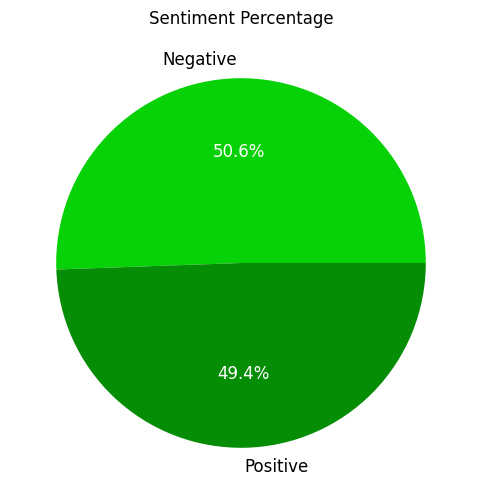

In [6]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

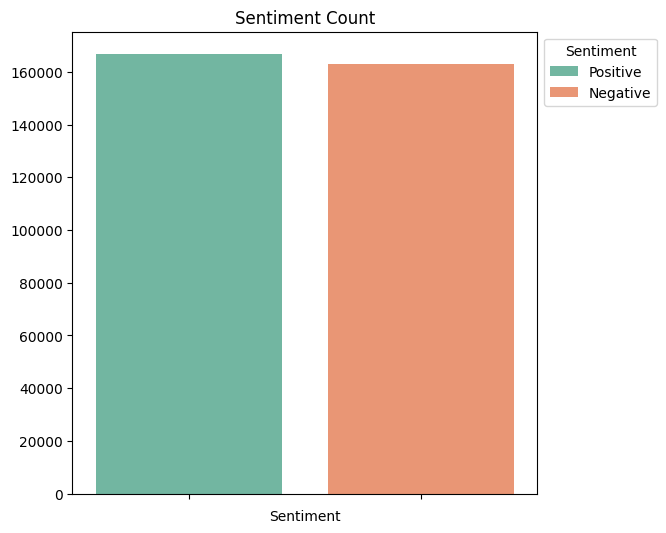

In [7]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

565782

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

2

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

28

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Text Normalization

In [12]:
Corpus["Number of Words 1"] = Corpus['Review'].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus["Number of Words 1"].sum()

22047249

# Average Number Of Words Before Text Normalization

In [13]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

67

# Maximum Number Of Word Before Text Normalization

In [14]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

197

# Minimum Number Of Words Before Text Normalization

In [15]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

0

In [16]:
Corpus[Corpus["Number of Words 1"] == 0]

,Sentiment,Review,NumberOfSentences,Number of Words 1
138547,Negative,/؟؟؟؟؟؟؟؟؟؟؟؟؟؟,1,0
148222,Negative,؟؟؟؟؟؟؟؟؟؟؟؟؟,1,0


# Number Of Charachters Before Text Normalization

In [17]:
Corpus["Number of Charachters 1"] = Corpus['Review'].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

93341349

# Average Number Of Charachters Before Text Normalization

In [18]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

283

# Maximum Number Of Charachters Before Text Normalization

In [19]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

850

# Minimum Number Of Charachters Before Text Normalization

In [20]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [21]:
Corpus[Corpus['Number of Charachters 1']==0]

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1
38715,Positive,(+_+).,1,1,0
43283,Positive,: 0.,1,1,0
71719,Positive,: 0.,1,1,0
119975,Negative,__________________ ؟!,1,1,0
138547,Negative,/؟؟؟؟؟؟؟؟؟؟؟؟؟؟,1,0,0
148222,Negative,؟؟؟؟؟؟؟؟؟؟؟؟؟,1,0,0
319452,Negative,&#1605 ؛ &#1593 ؛&#1575 ؛ &#1604 ؛ &#1575 ؛ &#...,1,91,0


# Most Frequent Words Before Text Normalization

In [22]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

,Word,Count
1,،,990466
2,من,635829
3,في,507780
4,على,360395
5,هذا,355550
6,أن,322842
7,إلى,189948
8,لا,185705
9,كان,119617
10,مع,119369


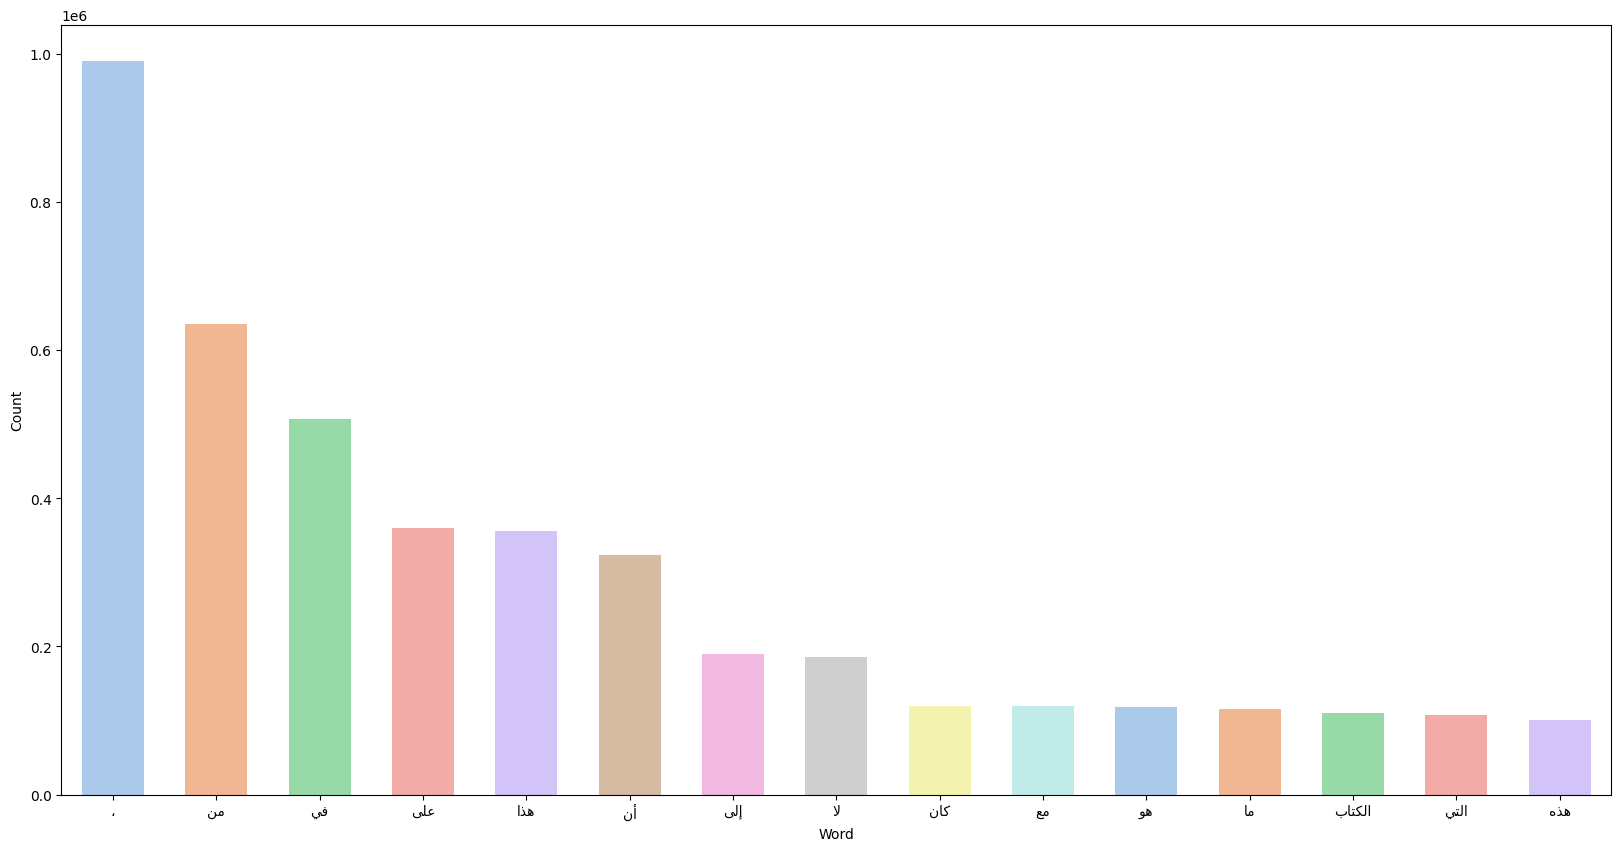

In [23]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Text Normalization

In [24]:
text_normalization = Text_Normalization(remove_emojis = True,
                                        remove_hashtags = True,
                                        remove_url = True,
                                        remove_mention = True,
                                        remove_html_tags = True,
                                        remove_new_line_char = True,
                                        remove_english_letter = True,
                                        remove_stop_words = True,
                                        remove_al = True,
                                        remove_arabic_diacritics = True,
                                        remove_arabic_tatweel = True,
                                        convert_gaf = True,
                                        convert_pe = True,
                                        convert_che = True,
                                        convert_ve = True,
                                        convert_alef = True,
                                        convert_alef_maqsura = True,
                                        convert_teh_marbuta = True,
                                        convert_kurdish_rah = False,
                                        convert_ayin = True,
                                        convert_la = True,
                                        convert_kurdish_tah = False,
                                        convert_kurdish_waw = False,
                                        convert_kurdish_kha = False,
                                        convert_kurdish_ga = False,
                                        remove_greek_letter = False,
                                        remove_mathematical_operators = True,
                                        remove_cyrillic_letter = True,
                                        remove_latin_letter = True,
                                        remove_currency = True,
                                        remove_punctuations = True,
                                        remove_number = True,
                                        remove_longest_than = True,
                                        remove_duplicate_word = True,
                                        remove_single_letter = True,
                                        remove_duplicated_letter = True,
                                        remove_unwanted_char = False,
                                        normalize_arabic_unicode = False,
                                        remove_unicode_and_special_character = True,
                                        remove_whitespace = True)


In [25]:
Corpus['Normalized_Review'] = Corpus['Review'].map(lambda x: text_normalization.text_normalization(x))
Corpus.dropna(axis=1, inplace=True)
Corpus.to_csv('Normalized Corpus.csv')

# Number Of Unique Words

In [26]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

197414

# WordCloud

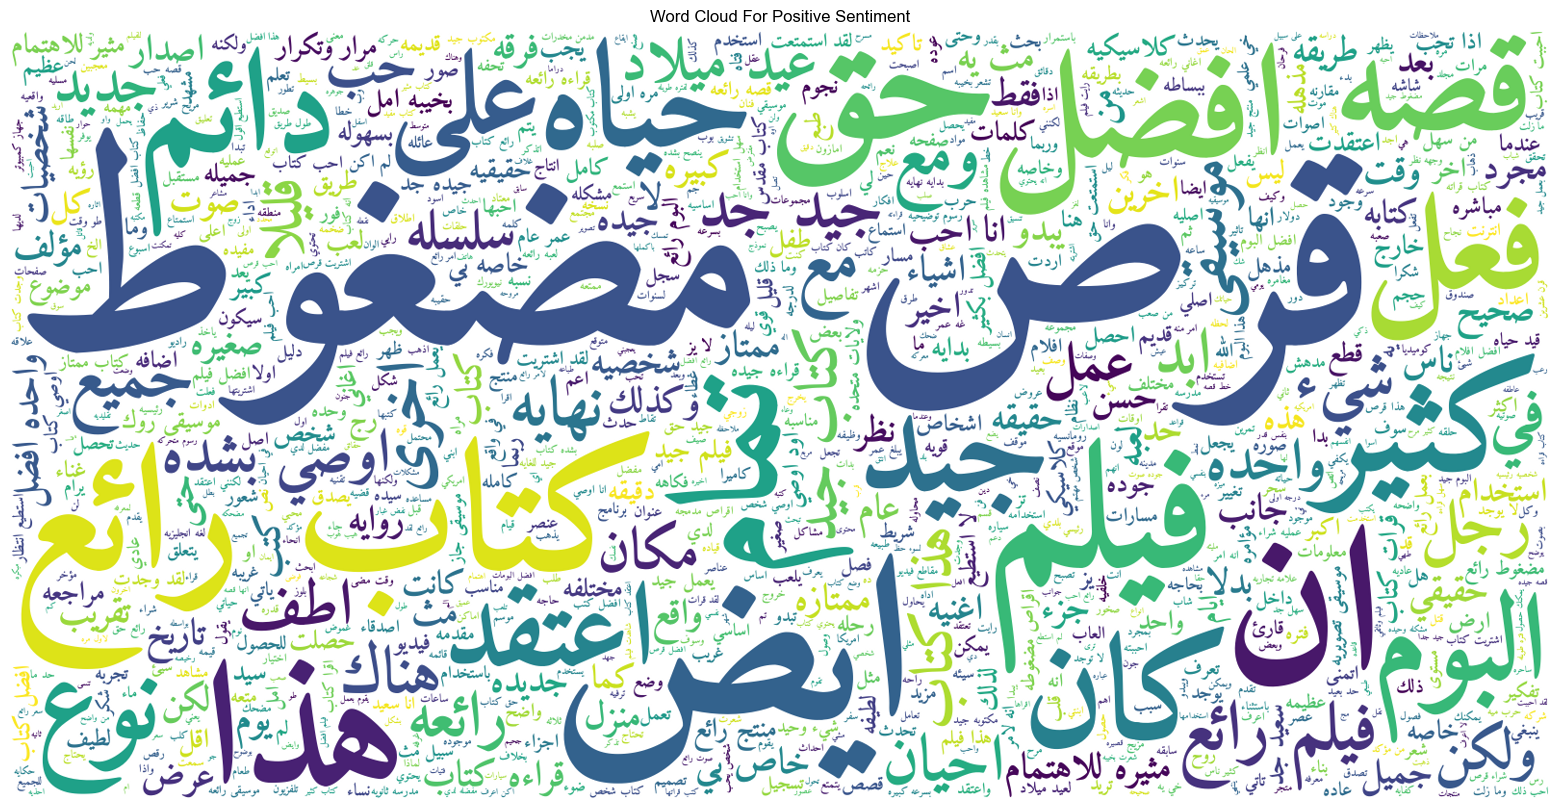

In [27]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

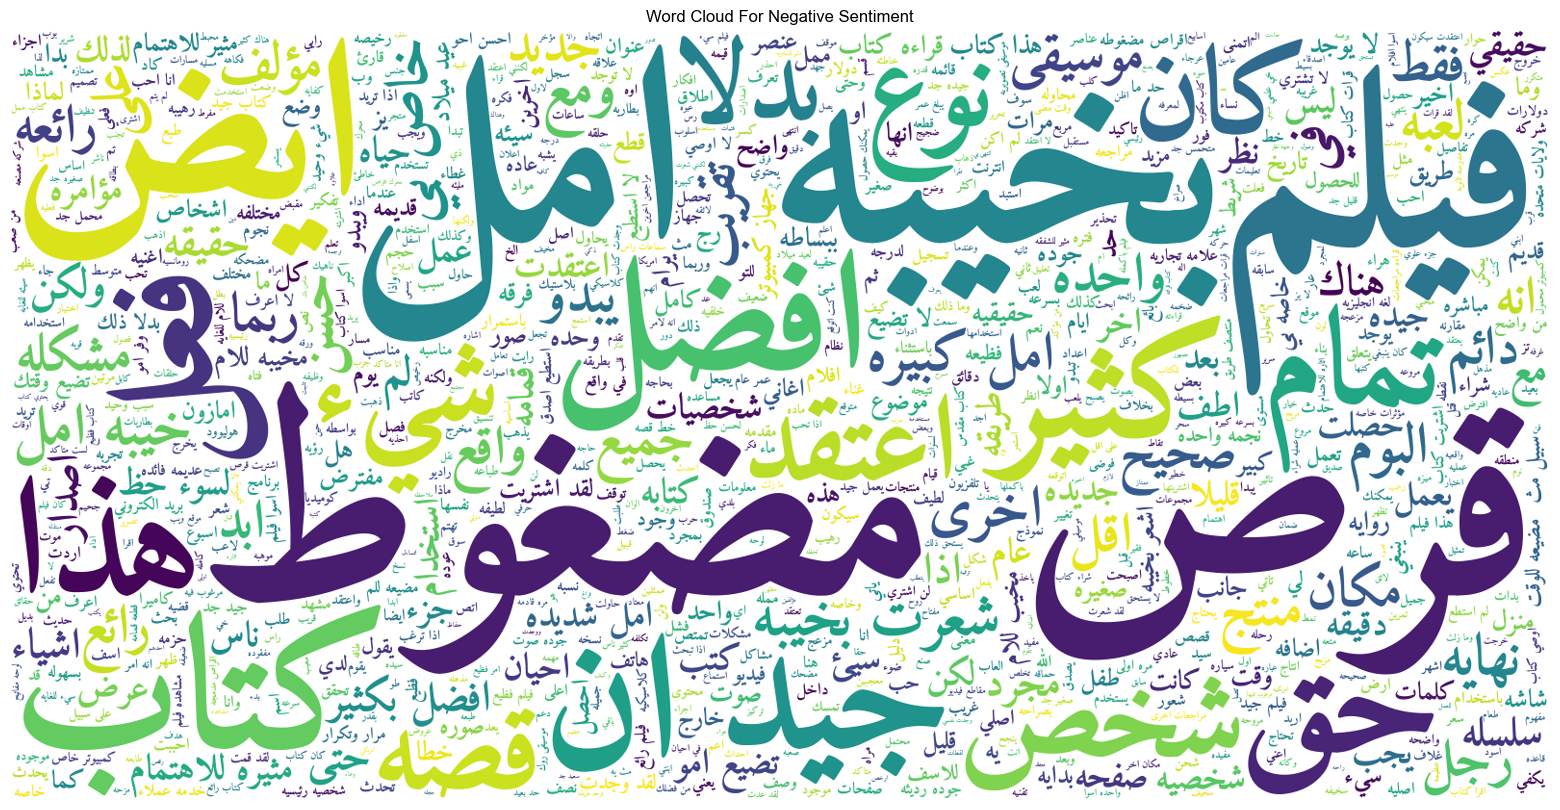

In [28]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Number Of Words After Text Normalization

In [29]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

13014425

# Average Number Of Words After Text Normalization

In [30]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

39

# Maximum Number Of Word After Text Normalization

In [31]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

122

# Minimum Number Of Words After Text Normalization

In [32]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Text Normalization

In [33]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 2"].sum()

57847183

# Average Number Of Charachters After Text Normalization

In [34]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

175

# Maximum Number Of Charachters After Text Normalization

In [35]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

582

# Minimum Number Of Charachters After Text Normalization

In [36]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

2

In [37]:
Corpus[Corpus['Number of Charachters 2']==0]

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review,Number of Words 2,Number of Charachters 2


# Most Frequent Words After Text Normalization

In [38]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

,Word,Count
1,كتاب,182935
2,فيلم,106108
3,جيد,80788
4,افضل,75324
5,رائع,73531
6,لقد,62404
7,لا,58741
8,قرص,55157
9,كثير,52138
10,هذا,51318


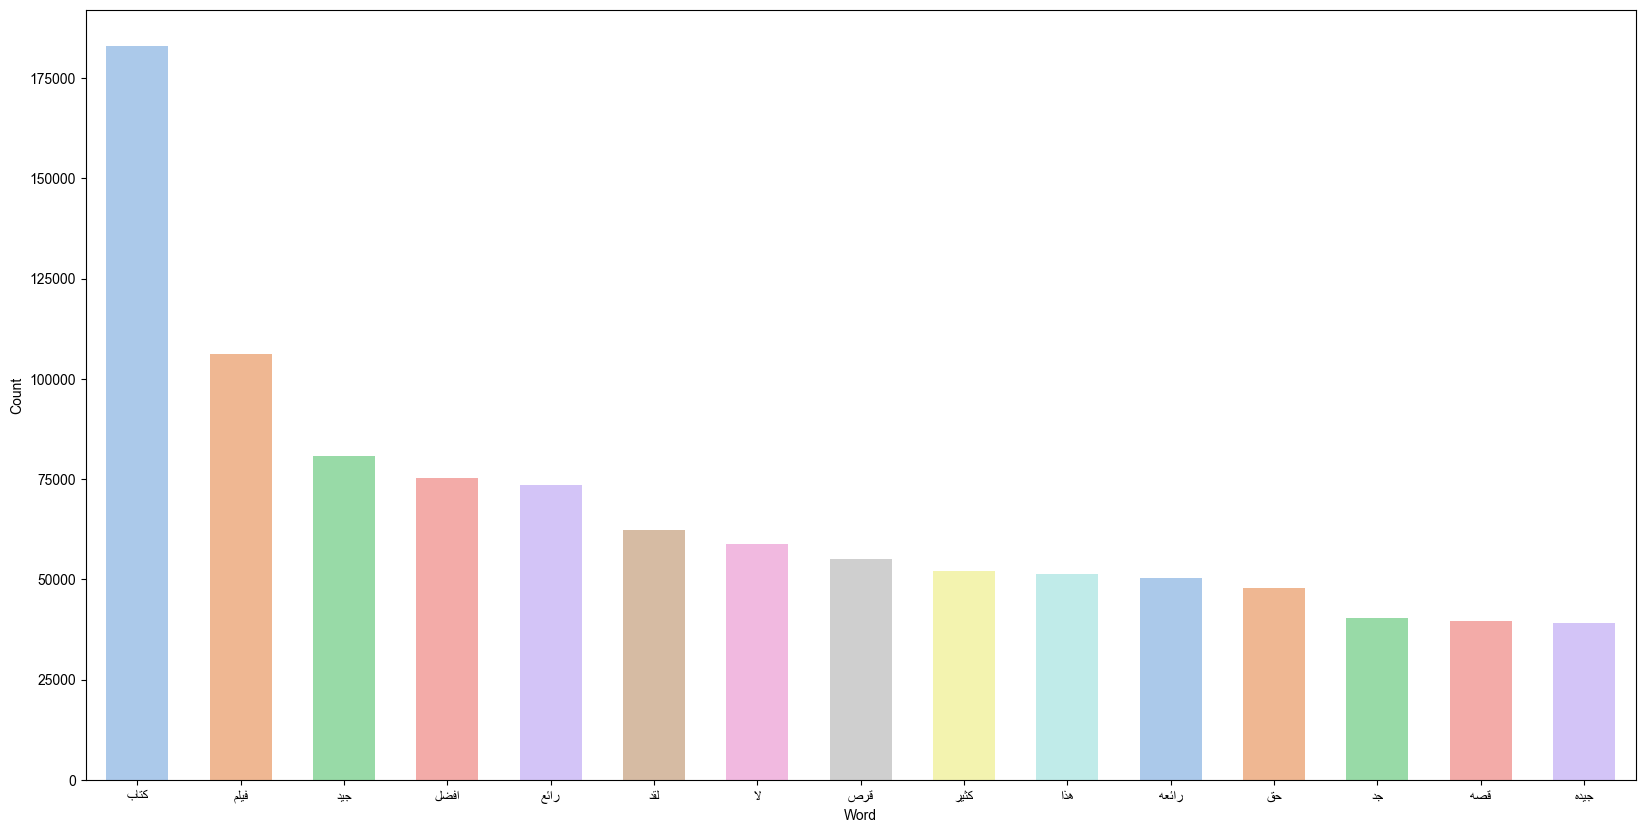

In [39]:
bar_plot(data=MostFrequentWordDF2, x = 'Word', y='Count' , text='Word')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [40]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [41]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

,Word,Count
1,كتاب,95195
2,رائع,58939
3,فيلم,49387
4,جيد,48624
5,افضل,45407
6,رائعه,38985
7,لقد,30237
8,قرص,29905
9,كثير,25984
10,حق,25754


**2-Negative**

In [42]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [43]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

,Word,Count
1,كتاب,87740
2,فيلم,56721
3,لا,39067
4,لقد,32167
5,جيد,32164
6,افضل,29917
7,هذا,26937
8,كثير,26154
9,قرص,25252
10,امل,24424


# Bigrams

In [44]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review,Number of Words 2,Number of Charachters 2,Bigrams
1,Negative,جودة صوت رديئة للغاية: لقد اشتريت محول الكاسيت...,1,78,329,جوده صوت رديئه للغايه اشتريت محول كاسيت استماع...,50,216,"[(جوده, صوت), (صوت, رديئه), (رديئه, للغايه), (..."
2,Negative,حكاية من عائدتين: لم أحصل على مقالي إلى موقد ا...,1,59,251,حكايه عائدتين احصل مق موقد مطبخ كان مقلاه حفرت...,39,182,"[(حكايه, عائدتين), (عائدتين, احصل), (احصل, مق)..."
3,Negative,ميل جيبسون ، عد إلى Austrailia!: ماذا بحق الجح...,4,123,547,ميل جيبسون عد بحق جحيم كاتب سيناريو يدخن لانني...,82,373,"[(ميل, جيبسون), (جيبسون, عد), (عد, بحق), (بحق,..."
4,Positive,Comic Classic: كان Gerry Sussman المتأخر ، محر...,1,40,171,متاخر محرر مضحك ببراعه ليس كثير كتاب مهاره لاس...,17,71,"[(متاخر, محرر), (محرر, مضحك), (مضحك, ببراعه), ..."
5,Negative,لا أستطيع قراءة هذه المادة لطفل !!: كنت متحمسً...,5,64,270,استطيع قراءه ماده لطفل متحمس طلب كتاب لقد خططت...,39,171,"[(استطيع, قراءه), (قراءه, ماده), (ماده, لطفل),..."
...,...,...,...,...,...,...,...,...,...
329981,Negative,SONICS السيئة ، التفسير السيئ - الحكم فقط عن ط...,2,92,384,سيئه تفسير سيئ طريق تسجيل تحذير تخترق اذنيك تخ...,47,194,"[(سيئه, تفسير), (تفسير, سيئ), (سيئ, طريق), (طر..."
329982,Negative,أعتقد أنني خارج الخطوة: أفترض أنه من الممكن أن...,1,94,390,اعتقد خارج خطوه افترض يتحدث رج كشخصيات كتاب لك...,55,246,"[(اعتقد, خارج), (خارج, خطوه), (خطوه, افترض), (..."
329983,Negative,كتاب غير لائق للأطفال: ليس فقط موضوع هذا الكتا...,1,62,284,كتاب لائق للاطف موضوع كتاب اساسي سلبيه ماري وا...,43,209,"[(كتاب, لائق), (لائق, للاطف), (للاطف, موضوع), ..."
329984,Positive,القرص المضغوط والحفل الموسيقي: واو!ذهبت إلى حف...,1,69,257,قرص مضغوط حفل موسيقي واو ذهبت حفل لندن رائع لم...,38,144,"[(قرص, مضغوط), (مضغوط, حفل), (حفل, موسيقي), (م..."


# Split The Dataset Into Dependent (X) And Independent (y)

In [45]:
X, y= Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [46]:
le = LabelEncoder()
y = le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33,  stratify=y)

# Vectorizer

In [48]:
Vectorizer = TfidfVectorizer()
X_train_Vec = Vectorizer.fit_transform(X_train)
X_test_Vec = Vectorizer.transform(X_test)

# Word Mapping

In [98]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.head()

,Word,Mapping
0,يضيف,172862
1,قوه,83446
2,عزم,73198
3,دوران,52212
4,اضافي,8096


# Machine Learning

**1-Naive Bayes**

In [50]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_Vec, y_train=y_train)

MultinomialNB(alpha=1)

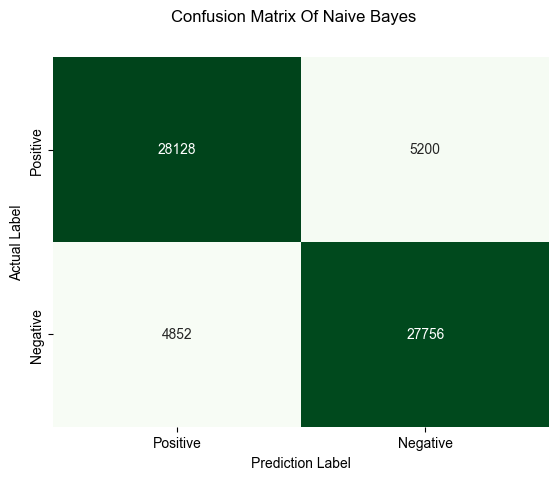

In [51]:
y_predNB = model_1.predict(X_test_Vec)
ConfusionMatrixNB = confusion_matrix_(y_test = y_test, y_pred = y_predNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(ConfusionMatrixNB)

In [52]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [53]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

,Values
Accuracy,0.847549
Precision,0.843975
Sensitivity,0.852881
Specificity,0.842214
F1Score,0.848404
Error,0.152451


**2-Logistic Regression**

In [54]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_Vec, y_train=y_train)

LogisticRegression()

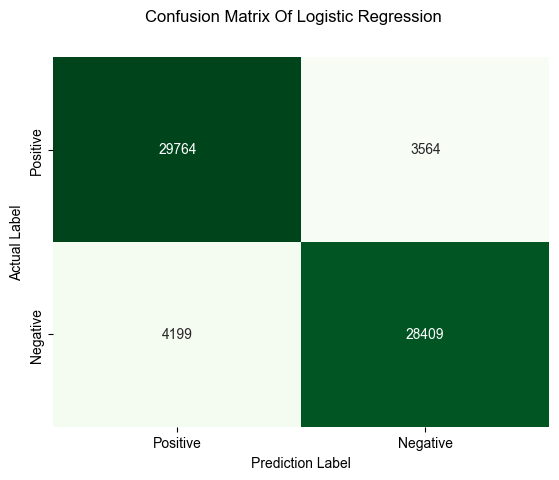

In [55]:
y_predLR = model_2.predict(X_test_Vec)
ConfusionMatrixLR = confusion_matrix_(y_test = y_test, y_pred = y_predLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(ConfusionMatrixLR)

In [56]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [57]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

,Values
Accuracy,0.882265
Precision,0.893063
Sensitivity,0.876365
Specificity,0.888531
F1Score,0.884635
Error,0.117735


**3-Decision Tree**

In [58]:
Algorithm = DecisionTreeClassifier(criterion='gini', )
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_Vec, y_train=y_train)

DecisionTreeClassifier()

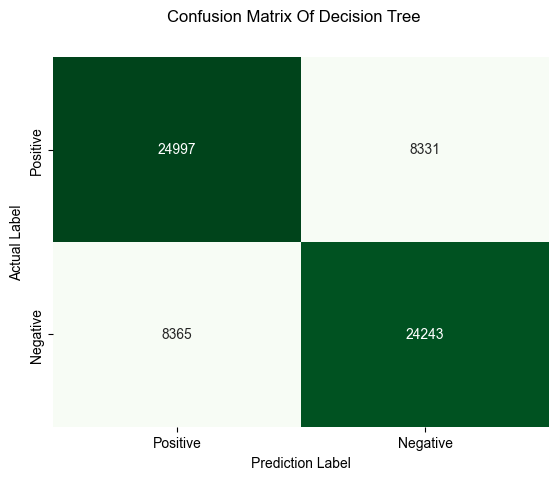

In [59]:
y_predDT = model_3.predict(X_test_Vec)
ConfusionMatrixDT = confusion_matrix_(y_test = y_test, y_pred = y_predDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(ConfusionMatrixDT)

In [60]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [61]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

,Values
Accuracy,0.746785
Precision,0.750030
Sensitivity,0.749266
Specificity,0.744244
F1Score,0.749648
Error,0.253215


**4-K Nearest Neighbors**

In [62]:
Algorithm =KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='distance', p=2)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_Vec, y_train=y_train)

KNeighborsClassifier(weights='distance')

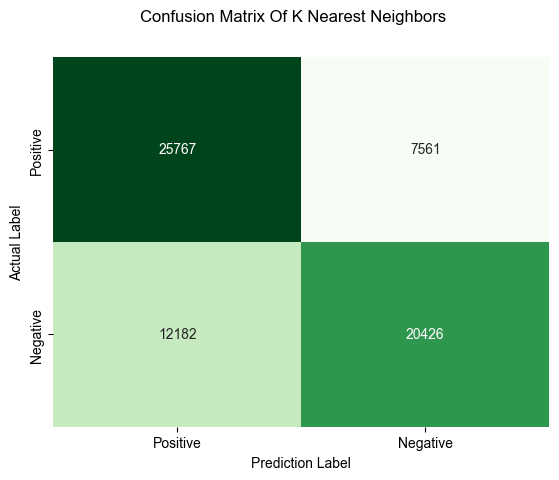

In [63]:
y_predKNN = model_4.predict(X_test_Vec)
ConfusionMatrixKNN = confusion_matrix_(y_test = y_test, y_pred = y_predKNN)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(ConfusionMatrixKNN)

In [64]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [65]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

,Values
Accuracy,0.700573
Precision,0.773134
Sensitivity,0.678990
Specificity,0.729839
F1Score,0.723010
Error,0.299427


**5-Random Forest**

In [66]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100, )
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_Vec, y_train=y_train)

RandomForestClassifier(criterion='entropy')

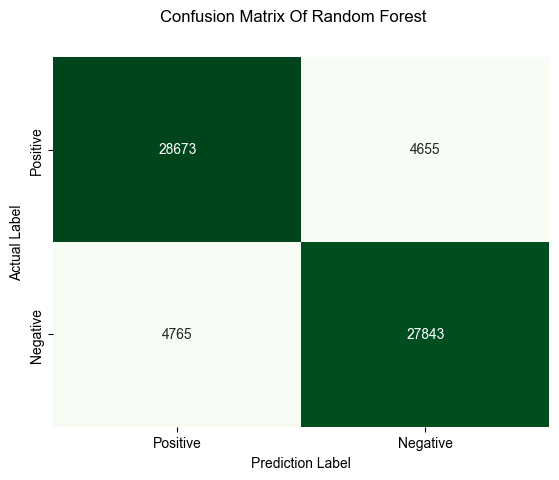

In [67]:
y_predRF = model_5.predict(X_test_Vec)
ConfusionMatrixRF = confusion_matrix_(y_test = y_test, y_pred = y_predRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(ConfusionMatrixRF)

In [68]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [69]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

,Values
Accuracy,0.857134
Precision,0.860328
Sensitivity,0.857497
Specificity,0.856760
F1Score,0.858910
Error,0.142866


**6-SGD Classifier**

In [70]:
Algorithm = SGDClassifier(loss='hinge', )
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_Vec, y_train=y_train)

SGDClassifier()

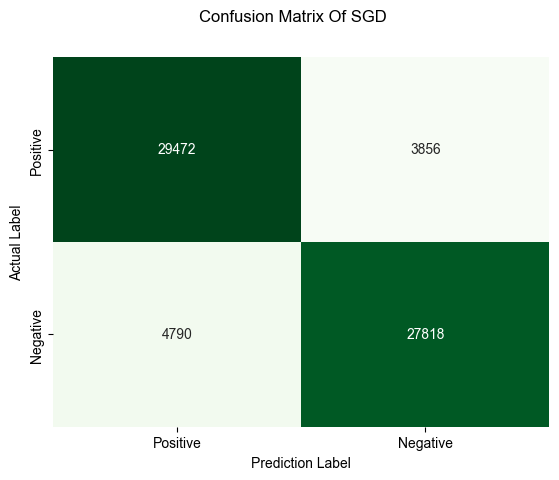

In [71]:
y_predSGD = model_6.predict(X_test_Vec)
ConfusionMatrixSGD = confusion_matrix_(y_test = y_test, y_pred = y_predSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(ConfusionMatrixSGD)

In [72]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [73]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

,Values
Accuracy,0.868873
Precision,0.884301
Sensitivity,0.860195
Specificity,0.878260
F1Score,0.872082
Error,0.131127


# Deep Learning

**1-Word To Integer (Tokenizer)**

In [74]:
all_words , words = data_words(data=(X_train.to_list() + X_test.to_list())) # Set With Unique Words And Find Number Of Unique Words
words_to_index = words_to_index_(words=words) # Convert Word To Integer Index
index_to_words = index_to_word_(words=words)
all_words

197416

**2-Data To Sequence**

In [75]:
X_train_sequences = text_to_sequence(word_index=words_to_index, data=X_train) # Convert Text Into Squences Of Integer
X_test_sequences = text_to_sequence(word_index=words_to_index, data=X_test) # Convert Text Into Squences Of Integer
max_length = len(max(X_train_sequences, key = len)) # Find Max Length

**3-Zero Padding**

In [76]:
encoded_X_train = sequences_padding(input_sequence=X_train_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)
encoded_X_test = sequences_padding(input_sequence=X_test_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)

In [77]:
print('The Vocab Size Is :', all_words)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 197416

The Max Length Is : 122


**4.Word Index**

In [97]:
Word_Index_ =pd.DataFrame(words_to_index.values(),  index = words_to_index.keys(), columns=['Index'])  
Word_Index_.tail()

,Index
اظفي,197411
خارجيه,197412
تكافحك,197413
فاتن,197414
بتقنيه,197415


**5-Word Occurrence**

In [79]:
word_count = word_counts(data=(X_train.to_list() + X_test.to_list())) # Number Of Occurrence Each Word
word_count_ =pd.DataFrame((list(word_count.items())), columns=['Word', 'Count'])
word_count_.head()

,Word,Count
0,كتاب,182935
1,فيلم,106108
2,جيد,80788
3,افضل,75324
4,رائع,73531


**6-Word Vector**

In [80]:
path = '/Users/osamaanmar/Downloads/Sentiment-Analysis-main/Arabic Sentiment Analysis/full_grams_cbow_100_twitter.mdl'
embedding_dim, word_vector = word_vector_(model_path = path, all_words = all_words , word_index = words_to_index)

# Deep Learing Models

**7-LSTM**

Epoch 1/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 850s 103ms/step - accuracy: 0.8319 - loss: 0.3658 - val_accuracy: 0.8904 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 2/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 813s 99ms/step - accuracy: 0.9086 - loss: 0.2269 - val_accuracy: 0.8925 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 3/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 804s 98ms/step - accuracy: 0.9364 - loss: 0.1662 - val_accuracy: 0.8867 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 4/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 805s 98ms/step - accuracy: 0.9571 - loss: 0.1165 - val_accuracy: 0.8784 - val_loss: 0.3852 - learning_rate: 0.0010
Test loss: 0.26523974537849426
Test accuracy: 0.8904088735580444


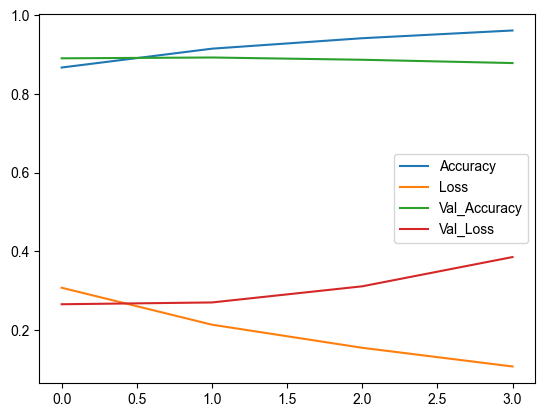

In [81]:
model_7 =lstm_(vocab_size = all_words , embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_7)
history = model_fit(model=model_7, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_7, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)       

**8-Bidirectional LSTM**

Epoch 1/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 1065s 129ms/step - accuracy: 0.8291 - loss: 0.3700 - val_accuracy: 0.8896 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 2/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 1050s 127ms/step - accuracy: 0.9084 - loss: 0.2280 - val_accuracy: 0.8914 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 3/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 1046s 127ms/step - accuracy: 0.9356 - loss: 0.1686 - val_accuracy: 0.8853 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 4/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 1054s 128ms/step - accuracy: 0.9563 - loss: 0.1205 - val_accuracy: 0.8762 - val_loss: 0.3822 - learning_rate: 0.0010
Test loss: 0.2666504383087158
Test accuracy: 0.8896050453186035


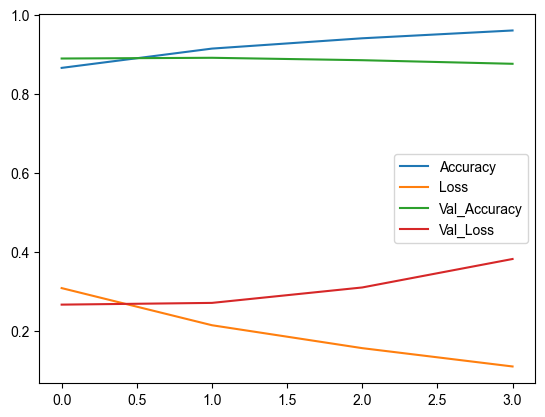

In [82]:
model_8 = bidirectional_lstm(vocab_size =all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_8, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

**9-GRU**

Epoch 1/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 802s 97ms/step - accuracy: 0.8240 - loss: 0.3741 - val_accuracy: 0.8897 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 2/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 796s 97ms/step - accuracy: 0.9075 - loss: 0.2260 - val_accuracy: 0.8891 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 3/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 797s 97ms/step - accuracy: 0.9368 - loss: 0.1641 - val_accuracy: 0.8820 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 4/10
8242/8242 ━━━━━━━━━━━━━━━━━━━━ 798s 97ms/step - accuracy: 0.9583 - loss: 0.1146 - val_accuracy: 0.8730 - val_loss: 0.3945 - learning_rate: 0.0010
Test loss: 0.2641098201274872
Test accuracy: 0.8896809220314026


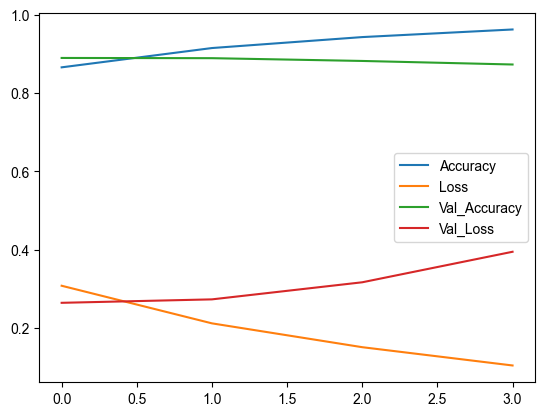

In [83]:
model_9 = gru_(vocab_size = all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_9, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [84]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Negative

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**2-Logistic Regression**

In [85]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Positive

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**3-Decision Tree**

In [86]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Positive

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**4-K Nearest Neighbors**

In [87]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Positive

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**5-Random Forest**

In [88]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Positive

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**6-SGD Classifier**

In [89]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Positive

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**7-LSTM**

In [90]:
deep_learning_inference(model = model_7, text = reviews, max_length = max_length, word_index = words_to_index)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Negative

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**8-Bidirectional LSTM**

In [91]:
deep_learning_inference(model = model_8, text = reviews, max_length = max_length, word_index = words_to_index)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Negative

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

**9-GRU**

In [92]:
deep_learning_inference(model = model_9, text = reviews, max_length = max_length, word_index = words_to_index)

Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Negative

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Positive

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا 

# Transformers

In [94]:
sentiment_analysis_transformers(reviews)

Device set to use mps:0


Review: بدس المتشددين: تنجح متابعة دييكاست للتراجع عن الأشرار مع أونسلاوغت كاملة من الأعطال الداخلية وما قد يسميه البعض كلمات مضادة للمجتمع ، أسميها كلمات رائعة.هذه الفرقة هي وزن ثقيل محدد ، واحصل على موافقة كاملة ، والامتنان غير المتجول.سيكون المشهد المتشددين في حيرة من العمر مع وجود هذا النطاقات.أريد أن أكون في هذه الفرقة ...
Sentiment: Neutral

Review: إنه جيد جدًا: حتى يتم تمييزه ، الأغاني رائعة.ولكن ، بعد ذلك يبدأون في النقص.إذا احتفظوا بأسلوب الطاعون الذي يستحق النغمة ، فسيكون هذا القرص المضغوط فائزًا.إنهم يأتون إلى هنا قريبًا مع A7X و Cannae.شراء هذا إذا كنت ترغب في الرقص عليه.المسارات البارزة: الطاعون واضطراب.
Sentiment: Negative

Review: عد بركاتك: لقد سمعت للتو جاكي بفلوج يتحدث في حدث أمس وكانت مذهلة.قصتها المذهلة وتصميمها على التعافي والبقاء إيجابية حقًا هي مصدر إلهام.اضطررت إلى الحصول على كتابها بعد سماع قصتها وهي تشرح حقًا سبب عدم تعرق الأشياء الصغيرة في الحياة.كانت ببساطة مذهلة وفجرتني بعيدًا.
Sentiment: Positive

Review: كلاسيكي بسيط: هذا الحجم صحيح تمامًا - ليس طويلًا ج